<h2 align="center"> Project Introduction <h2/>

The main purpose of this project for me was to remember and apply new knowledge that I acquired during my graduation and also during my recent vacation. The Excel datasheet data was obtained by a Web Scraping Bot using UiPath RPA (*source: Quinto Andar, https://www.quintoandar.com.br)*.

Afterward, I decided to clean the data and conduct a data exploration to eventually attempt to predict the price value of a building based on some characteristics. Below, you will find an overview of the dataset.

In this project, I was able to enhance the following skills:

- Web Scraping using RPA from UiPath
- Data cleaning and exploration using <code>pandas</code> in Python
- Deep Learning with <code>pytorch</code>

Project duration: 2 days

The Excel file is composed by the following columns:

Column           | Description| Unit
:-----:|:------:|---:|
PropertyType     | Type of property (Apartment, House, Condominium, Studio) | --    |
Price            | Price of the building  | Brazilian Reais  
PropertyDetails  | Additional information (Number of Rooms, etc.)  | --
Address          | Street, District, and City     | --    
URL              | Link to Quinto Andar Website  | --  
CondominiumFee   | Price of cond                 | Brazilian Reais


______
<h2> ❑ Table of Contents</h2>

- [Importing python libraries](#imp)

- [Loading the Data](#get)

- [Data Preparation](#prep)

- [Data Exploration](#exp)

- [Prediction with pytorch](#pred)

- [Conclusions](#conc)

- [Future Work](#fut)

- [References](#ref)

______
<div id="imp"></div>
<h2 align="center"> Importing Libraries</h2>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import geopandas as gpd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.linear_model import Ridge

# Obtain the same result always
torch.manual_seed(1)
np.random.seed(1)
warnings.filterwarnings("ignore")

______
<div id="get"></div>
<h2 align="center"> Loading Data</h2>

The first step is to load the data from the excel sheet <code>data.xlsx</code>

In [2]:
df = pd.read_excel('data.xlsx', header=0)
df.head()

,TipoImovel,Preco,Condominio,DadosImovel,Endereco,URL
0,Casa,R$ 200.000,R$ 0 Condo. + IPTU,105 m² · 2 quartos · 3 vagas,"Rua Raul Seixas, União Vila Nova · São Paulo",https://www.quintoandar.com.br/imovel/89436349...
1,Apartamento,R$ 350.000,R$ 700 Condo. + IPTU,100 m² · 3 quartos · 2 vagas,"Avenida Ordem E Progresso, Jardim das Laranjei...",https://www.quintoandar.com.br/imovel/89436790...
2,Apartamento,R$ 3.000.000,R$ 2.291 Condo. + IPTU,130 m² · 1 quarto · 2 vagas,"Rua Silva Correia, Vila Nova Conceição · São P...",https://www.quintoandar.com.br/imovel/89437132...
3,Apartamento,R$ 430.000,R$ 385 Condo. + IPTU,600 m² · 2 quartos · 1 vaga,"Rua Cajuru, Belenzinho · São Paulo",https://www.quintoandar.com.br/imovel/89436734...
4,Apartamento,R$ 200.000,R$ 170 Condo. + IPTU,56 m² · 2 quartos · 1 vaga,"Rua Domingos Rubino, Conjunto Residencial José...",https://www.quintoandar.com.br/imovel/89436949...


In [3]:
print("Length of dataframe: ", len(df))

Length of dataframe:  1000


______
<div id="prep"></div>
<h2 align="center"> Data Preparation</h2>

As you have observed, the data is in Portuguese, and in some columns, two or three features are combined. Let's translate it into English, filter, and rearrange the column order for improved visualization.

In [4]:
# Renaming columns and series values to english
df = df.rename(columns={"Preco" : "Price (R$)", "TipoImovel" : "PropertyType", "Condominio" : "CondominiumFee (R$)", 
                  "DadosImovel" : "PropData", "Endereco" : "Address"})

# Translating it to english
df["PropertyType"] = df["PropertyType"].replace({"Casa" : "House" , "Apartamento" : "Apartment", 
                                                 "Studio e kitnet": "Studio/Kitnet", 
                                                 "Casa em condomínio" : "CondominiumHouse", "Lançamento" : "Release"})
df.head()

,PropertyType,Price (R$),CondominiumFee (R$),PropData,Address,URL
0,House,R$ 200.000,R$ 0 Condo. + IPTU,105 m² · 2 quartos · 3 vagas,"Rua Raul Seixas, União Vila Nova · São Paulo",https://www.quintoandar.com.br/imovel/89436349...
1,Apartment,R$ 350.000,R$ 700 Condo. + IPTU,100 m² · 3 quartos · 2 vagas,"Avenida Ordem E Progresso, Jardim das Laranjei...",https://www.quintoandar.com.br/imovel/89436790...
2,Apartment,R$ 3.000.000,R$ 2.291 Condo. + IPTU,130 m² · 1 quarto · 2 vagas,"Rua Silva Correia, Vila Nova Conceição · São P...",https://www.quintoandar.com.br/imovel/89437132...
3,Apartment,R$ 430.000,R$ 385 Condo. + IPTU,600 m² · 2 quartos · 1 vaga,"Rua Cajuru, Belenzinho · São Paulo",https://www.quintoandar.com.br/imovel/89436734...
4,Apartment,R$ 200.000,R$ 170 Condo. + IPTU,56 m² · 2 quartos · 1 vaga,"Rua Domingos Rubino, Conjunto Residencial José...",https://www.quintoandar.com.br/imovel/89436949...


In [5]:
# Checking which types are in Property Type
df.PropertyType.value_counts()

Apartment           761
House               106
Studio/Kitnet       104
CondominiumHouse     28
Release               1
Name: PropertyType, dtype: int64

In [6]:
# Filtering strings in Price and Condominuim Fee
df["Price (R$)"] = df["Price (R$)"].str.replace("[R$.]", "")
df["CondominiumFee (R$)"] = df["CondominiumFee (R$)"].str.replace("[R$Condo.IPTU+]", "")

# Separate PropDate into three new columns
df[['SqrMeter', 'NumRooms', 'ParkSpace']] = df['PropData'].str.extract(
    r'(?P<SqrMeter>\d+) m² · (?P<NumRooms>\d+) quarto[s]? · (?P<ParkSpace>\d+) vaga[s]?')

# Separating Address into three new columns
df[['Street', 'District', 'City']] = df['Address'].str.extract(
    r'(?P<Street>.*), (?P<City>.*) · (?P<District>.*)')

# Reducing name of a district 
df.District = df.District.replace("Conjunto Residencial José Bonifácio", "José Bonifácio")

# Dropping rows with NaNs
df = df.dropna()

df.head()

,PropertyType,Price (R$),CondominiumFee (R$),PropData,Address,URL,SqrMeter,NumRooms,ParkSpace,Street,District,City
0,House,200000,0,105 m² · 2 quartos · 3 vagas,"Rua Raul Seixas, União Vila Nova · São Paulo",https://www.quintoandar.com.br/imovel/89436349...,105,2,3,Rua Raul Seixas,União Vila Nova,São Paulo
1,Apartment,350000,700,100 m² · 3 quartos · 2 vagas,"Avenida Ordem E Progresso, Jardim das Laranjei...",https://www.quintoandar.com.br/imovel/89436790...,100,3,2,Avenida Ordem E Progresso,Jardim das Laranjeiras,São Paulo
2,Apartment,3000000,2291,130 m² · 1 quarto · 2 vagas,"Rua Silva Correia, Vila Nova Conceição · São P...",https://www.quintoandar.com.br/imovel/89437132...,130,1,2,Rua Silva Correia,Vila Nova Conceição,São Paulo
3,Apartment,430000,385,600 m² · 2 quartos · 1 vaga,"Rua Cajuru, Belenzinho · São Paulo",https://www.quintoandar.com.br/imovel/89436734...,600,2,1,Rua Cajuru,Belenzinho,São Paulo
4,Apartment,200000,170,56 m² · 2 quartos · 1 vaga,"Rua Domingos Rubino, Conjunto Residencial José...",https://www.quintoandar.com.br/imovel/89436949...,56,2,1,Rua Domingos Rubino,José Bonifácio,São Paulo


In [7]:
print("Len of dataframe: ", len(df))

Len of dataframe:  703


In [8]:
# Dropping PropData as now is not more useful
df = df.drop('PropData', axis=1) 
df = df.drop('Address', axis=1)
df.head()

,PropertyType,Price (R$),CondominiumFee (R$),URL,SqrMeter,NumRooms,ParkSpace,Street,District,City
0,House,200000,0,https://www.quintoandar.com.br/imovel/89436349...,105,2,3,Rua Raul Seixas,União Vila Nova,São Paulo
1,Apartment,350000,700,https://www.quintoandar.com.br/imovel/89436790...,100,3,2,Avenida Ordem E Progresso,Jardim das Laranjeiras,São Paulo
2,Apartment,3000000,2291,https://www.quintoandar.com.br/imovel/89437132...,130,1,2,Rua Silva Correia,Vila Nova Conceição,São Paulo
3,Apartment,430000,385,https://www.quintoandar.com.br/imovel/89436734...,600,2,1,Rua Cajuru,Belenzinho,São Paulo
4,Apartment,200000,170,https://www.quintoandar.com.br/imovel/89436949...,56,2,1,Rua Domingos Rubino,José Bonifácio,São Paulo


In [9]:
# Changing the order of the columns
cols = df.columns.tolist()
cols = ['City', 'District', 'Street',  
        'PropertyType','SqrMeter','NumRooms','ParkSpace', 
        'Price (R$)', 'CondominiumFee (R$)', 'URL']
df = df[cols]
df.head()

,City,District,Street,PropertyType,SqrMeter,NumRooms,ParkSpace,Price (R$),CondominiumFee (R$),URL
0,São Paulo,União Vila Nova,Rua Raul Seixas,House,105,2,3,200000,0,https://www.quintoandar.com.br/imovel/89436349...
1,São Paulo,Jardim das Laranjeiras,Avenida Ordem E Progresso,Apartment,100,3,2,350000,700,https://www.quintoandar.com.br/imovel/89436790...
2,São Paulo,Vila Nova Conceição,Rua Silva Correia,Apartment,130,1,2,3000000,2291,https://www.quintoandar.com.br/imovel/89437132...
3,São Paulo,Belenzinho,Rua Cajuru,Apartment,600,2,1,430000,385,https://www.quintoandar.com.br/imovel/89436734...
4,São Paulo,José Bonifácio,Rua Domingos Rubino,Apartment,56,2,1,200000,170,https://www.quintoandar.com.br/imovel/89436949...


In [10]:
# Assigning variable types to columns:
df['SqrMeter'] = df['SqrMeter'].astype(float)
df['NumRooms'] = df['NumRooms'].astype(float)
df['ParkSpace'] = df['ParkSpace'].astype(float)
df['Price (R$)'] = df['Price (R$)'].astype(float)
df['CondominiumFee (R$)'] = df['CondominiumFee (R$)'].astype(float)

______
<div id="exp"></div>
<h2 align="center"> Data Exploration</h2>

Now we are going to do some data explorating to understand it better.

In [11]:
# Seeing describe values:
df.describe()

,SqrMeter,NumRooms,ParkSpace,Price (R$),CondominiumFee (R$)
count,703.000000,703.000000,703.000000,7.030000e+02,703.000000
mean,151.219061,2.098151,1.388336,6.013370e+05,668.883357
std,1655.153003,0.710350,0.879478,7.062621e+05,640.301552
min,1.000000,1.000000,1.000000,1.900000e+05,0.000000
25%,51.000000,2.000000,1.000000,2.800000e+05,281.500000
50%,64.000000,2.000000,1.000000,3.900000e+05,552.000000
75%,88.000000,2.000000,2.000000,6.000000e+05,817.000000
max,43900.000000,6.000000,8.000000,1.142000e+07,7436.000000


In [12]:
# Seeing how much buildings exist per districts
df.District.value_counts()

Bela Vista                      28
Cambuci                         25
José Bonifácio                  18
Mooca                           17
Vila Mariana                    15
                                ..
Vila Cleonice                    1
Imirim                           1
Sé                               1
Jardim Brasília (zona Norte)     1
Vila Santa Teresa                1
Name: District, Length: 267, dtype: int64

In [13]:
# Filtering districts that have at least 6 samples
df_filt = df[df.groupby('District')['District'].transform('count') >= 6]
df_filt.head()

,City,District,Street,PropertyType,SqrMeter,NumRooms,ParkSpace,Price (R$),CondominiumFee (R$),URL
4,São Paulo,José Bonifácio,Rua Domingos Rubino,Apartment,56.0,2.0,1.0,200000.0,170.0,https://www.quintoandar.com.br/imovel/89436949...
11,São Paulo,Vila Prudente,Rua Rio Duas Barras,Apartment,50.0,2.0,1.0,200000.0,245.0,https://www.quintoandar.com.br/imovel/89436842...
12,São Paulo,Brás,Rua Domingos Paiva,Apartment,123.0,1.0,1.0,2050000.0,1067.0,https://www.quintoandar.com.br/imovel/89357737...
13,São Paulo,Bela Vista,Avenida Nove de Julho,Apartment,56.0,1.0,1.0,250000.0,558.0,https://www.quintoandar.com.br/imovel/89414515...
17,São Paulo,Campo Belo,Rua Doutor Jesuíno Maciel,Apartment,70.0,1.0,1.0,1250000.0,1567.0,https://www.quintoandar.com.br/imovel/89436195...


In [14]:
# Mean value per district
mean_per_district = df_filt.groupby('District')['Price (R$)'].mean()

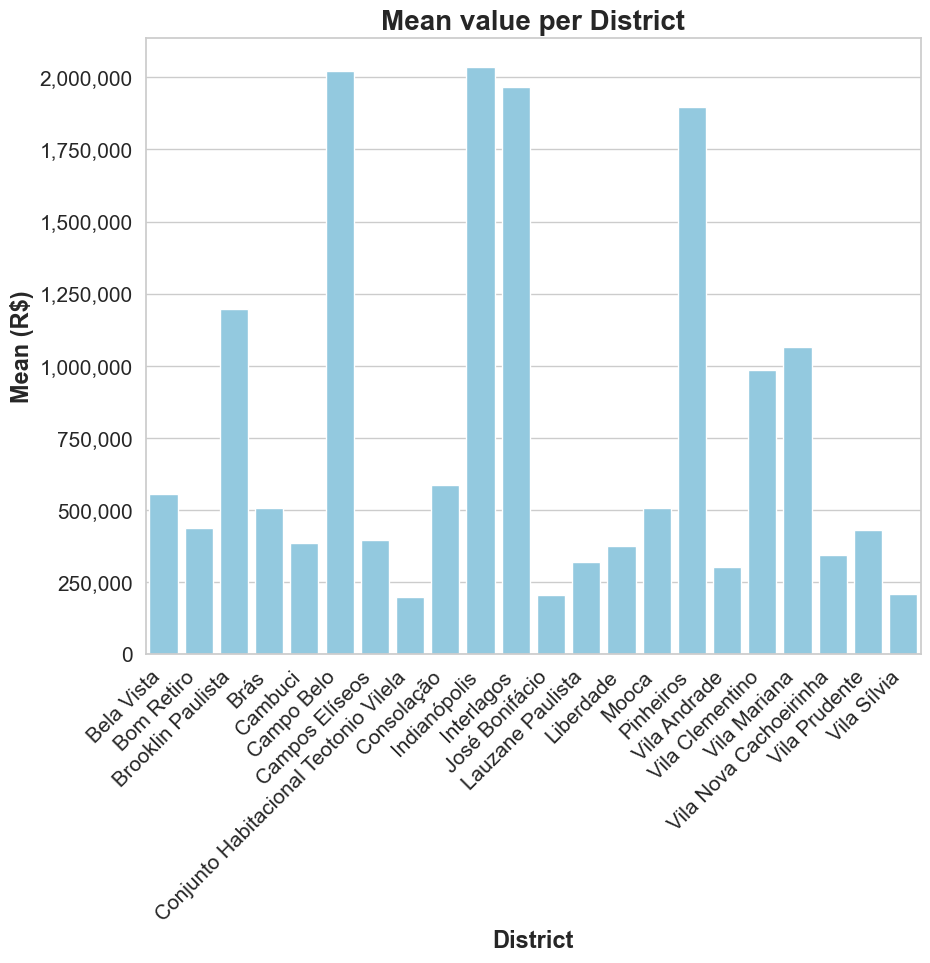

In [15]:
# Plotting data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_per_district.index, y=mean_per_district.values, color='skyblue')
plt.title('Mean value per District', fontsize=20, fontdict={'weight': 'bold'})
plt.xlabel('District', fontsize=17, fontdict={'weight': 'bold'})
plt.ylabel('Mean (R$)', fontsize=17, fontdict={'weight': 'bold'})

# y axis config
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
plt.xticks(rotation=45, ha='right')

plt.tick_params(axis='both', which='both', labelsize=15)
plt.show()

In [16]:
# GeoInfo from São Paulo City
shapefile_path = 'DEINFO_DISTRITO.shp'
bairros_sp = gpd.read_file(shapefile_path)
bairros_destacados = [x.upper() for x in list(mean_per_district.index)]

# Filterin data
bairros_destacados_df = bairros_sp[bairros_sp['NOME_DIST'].isin(bairros_destacados)]

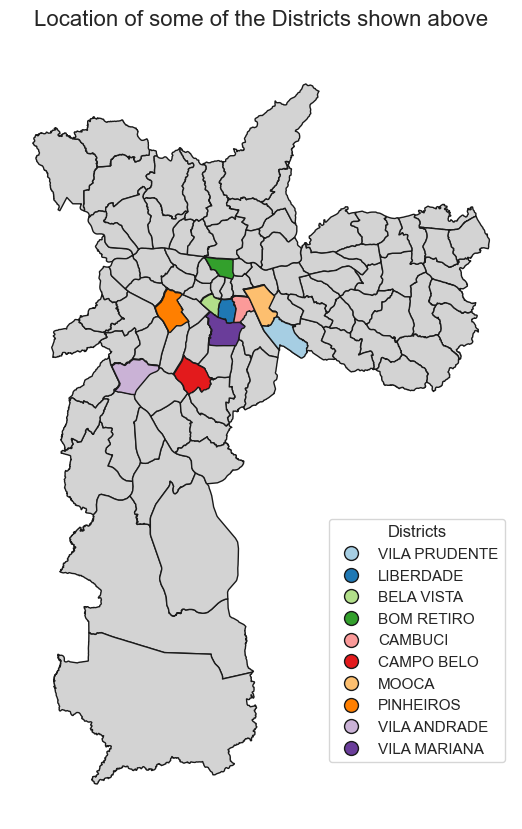

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

#All districts
bairros_sp.plot(ax=ax, edgecolor='k', color='lightgrey')

# Color map config
legend_elements = []
colors = cm.Paired(range(len(bairros_destacados)))

# Plotando bairros destacados e adicionando à legenda
for i, (idx, row) in enumerate(bairros_destacados_df.iterrows()):
    nome_bairro = row['NOME_DIST']
    cor_bairro = colors[i]
    
    # Drawing legend
    linha_bairro = Line2D([0], [0], marker='o', color='w', label=nome_bairro, 
                         markersize=10, markerfacecolor=cor_bairro, markeredgecolor='k')
    legend_elements.append(linha_bairro)
    
    # Plotting
    bairros_destacados_df[bairros_destacados_df['NOME_DIST'] == nome_bairro].plot(ax=ax, color=cor_bairro, edgecolor='k')

plt.title('Location of some of the Districts shown above', fontsize=16)
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 0.4), title='Districts')
plt.axis('off')  
plt.show()

In [18]:
# Mean value per property type
mean_per_proptype = df.groupby('PropertyType')['Price (R$)'].mean()

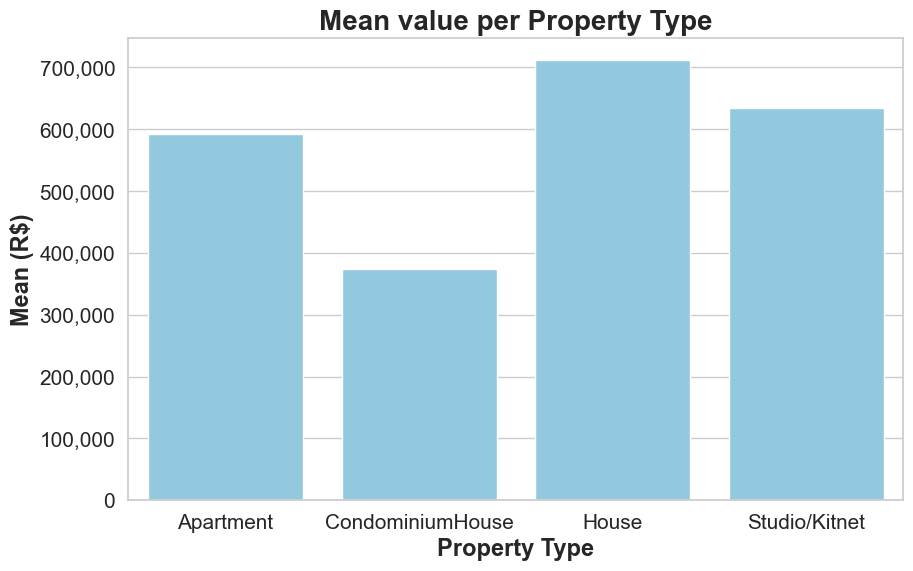

In [19]:
# Plotting data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_per_proptype.index, y=mean_per_proptype.values, color='skyblue')
plt.title('Mean value per Property Type', fontsize=20, fontdict={'weight': 'bold'})
plt.xlabel('Property Type', fontsize=17, fontdict={'weight': 'bold'})
plt.ylabel('Mean (R$)', fontsize=17, fontdict={'weight': 'bold'})

# y axis config
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.tick_params(axis='both', which='both', labelsize=15)
plt.show()

In [20]:
# Mean number of rooms, parking and square meter from the different type of buildings
filtro = df.loc[df.PropertyType == 'Apartment', ['PropertyType','SqrMeter', 'NumRooms', 'ParkSpace']]

count = df.groupby('PropertyType', as_index=False)[['SqrMeter', 'NumRooms', 'ParkSpace']].mean().round()
count_melted = pd.melt(count, id_vars='PropertyType', var_name='Feature', value_name='Mean')
count_melted.head()

,PropertyType,Feature,Mean
0,Apartment,SqrMeter,151.0
1,CondominiumHouse,SqrMeter,74.0
2,House,SqrMeter,198.0
3,Studio/Kitnet,SqrMeter,38.0
4,Apartment,NumRooms,2.0


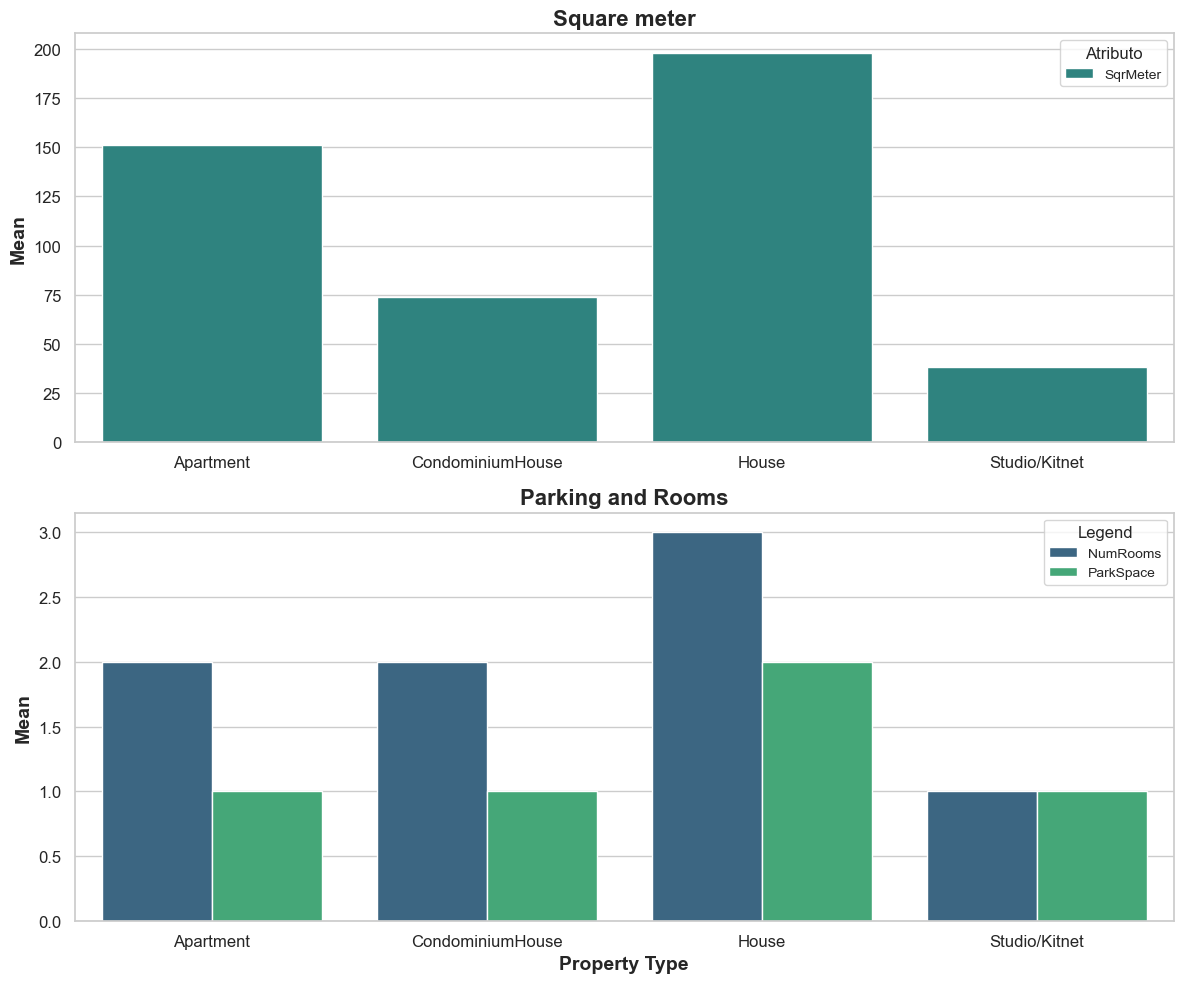

In [21]:
# Separating datasets
metros_quadrados = count_melted[count_melted['Feature'] == 'SqrMeter']
vagas_banheiros = count_melted[count_melted['Feature'].isin(['NumRooms', 'ParkSpace'])]

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Subplot for square meter
sns.barplot(x='PropertyType', y='Mean', data=metros_quadrados, hue='Feature', palette='viridis', ax=axes[0])
axes[0].set_title('Square meter', fontsize=16, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='both', which='both', labelsize=12)
axes[0].legend(title='Atributo', title_fontsize='12', fontsize='10')

# Subplot for parking and rooms
sns.barplot(x='PropertyType', y='Mean', data=vagas_banheiros, hue='Feature', palette='viridis', ax=axes[1])
axes[1].set_title('Parking and Rooms', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Property Type', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='both', which='both', labelsize=12)
axes[1].set_ylabel('Mean', fontsize=14, fontweight='bold')
axes[1].legend(title='Legend', title_fontsize='12', fontsize='10')

plt.tight_layout()
plt.show()

It is beneficial to examine the correlation matrix, especially when your goal is to predict a value. This allows you to discern which features are related to the target. However, it's crucial to note that correlation does not imply causality, and relying solely on this metric can potentially result in a misinterpretation of the data. Additionally, one must consider that features may have different units, making direct comparisons sometimes impractical.

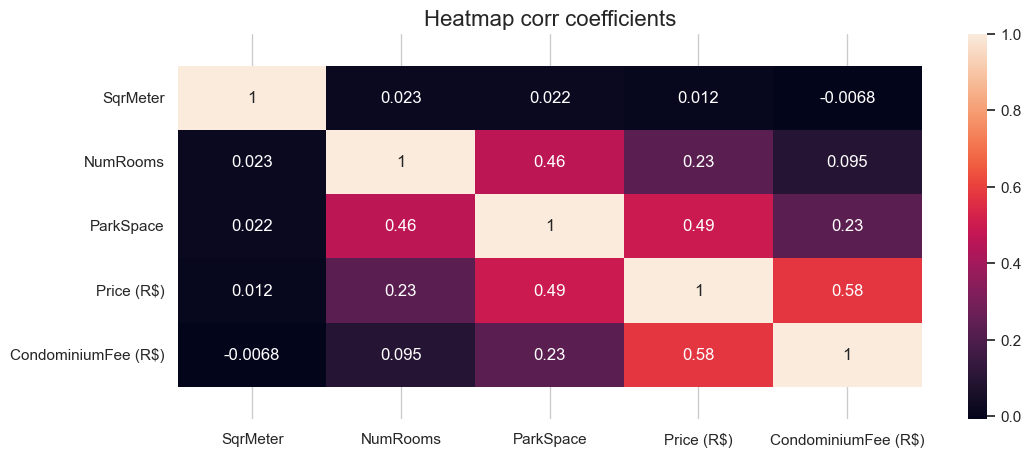

In [22]:
# Correlation matrix
corr = df.corr()

# Heat Map
plt.figure(figsize = (12,5))
plt.title('Heatmap corr coefficients', fontsize=16)
ax = sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)
baixo, topo = ax.get_ylim()

ax.set_ylim(baixo + 0.5, topo - 0.5)
plt.show()

The correlation coefficient measures the strength and direction of the linear relationship between two variables. The value of the correlation coefficient ranges from -1 to 1:

- If the value is 1, there is a perfect positive correlation, indicating that the variables increase together in a linear relationship.
- If the value is -1, there is a perfect negative correlation, indicating that the variables decrease together in a linear relationship.
- If the value is 0, there is no linear correlation between the variables.

Therefore, the closer the value of the correlation coefficient is to 1 (positive) or -1 (negative), the stronger the linear relationship between the variables. However, it's important to note that correlation does not imply causation, and other factors may be involved in the relationship between variables. Additionally, correlation **does not capture non-linear relationships**.

______
<div id="pred"></div>
<h2 align="center"> Predicting with pytorch</h2>

Now we are going to explore <code>pytorch</code> and FNN. 

In [23]:
# Dropping unuseful columns
df_neuron = df.drop(['URL', 'City', 'Street', 'District'], axis=1) 
df_neuron.head()

,PropertyType,SqrMeter,NumRooms,ParkSpace,Price (R$),CondominiumFee (R$)
0,House,105.0,2.0,3.0,200000.0,0.0
1,Apartment,100.0,3.0,2.0,350000.0,700.0
2,Apartment,130.0,1.0,2.0,3000000.0,2291.0
3,Apartment,600.0,2.0,1.0,430000.0,385.0
4,Apartment,56.0,2.0,1.0,200000.0,170.0


First, we need to apply One-Hot-Encoding to the categorical variables to facilitate prediction. Afterward, we can separate the remaining dataset into features (X) and the target variable (Y). Finally, we can apply the <code>train_test_split</code> method from the <code>sklearn</code> library.

In [24]:
df_neuron = pd.get_dummies(df_neuron, columns=['PropertyType'])

# Defining targets and features
X = df_neuron.drop(columns=['Price (R$)'])
y = df_neuron['Price (R$)']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Then we have to normalize the data (as there is a wide variety—price can have 5-6 units, while rooms have only one) and convert the train and test datasets into <code>pyTorch</code> tensors.

In [25]:
# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting to Pytorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1) 

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print("X_train: ", X_train.head())

X_train:       SqrMeter  NumRooms  ParkSpace  CondominiumFee (R$)  \
233      52.0       2.0        1.0                350.0   
323      78.0       2.0        1.0                560.0   
404     114.0       2.0        2.0                 10.0   
366      89.0       2.0        2.0                180.0   
164     104.0       2.0        1.0                809.0   

     PropertyType_Apartment  PropertyType_CondominiumHouse  \
233                       1                              0   
323                       1                              0   
404                       0                              0   
366                       1                              0   
164                       1                              0   

     PropertyType_House  PropertyType_Studio/Kitnet  
233                   0                           0  
323                   0                           0  
404                   1                           0  
366                   0                       

In [26]:
print("X_train_scaled: ", X_train_scaled[0])

X_train_scaled:  [-0.0620488  -0.1360581  -0.44109177 -0.49026273  0.5016676  -0.19702032
 -0.40144368 -0.15983568]


In [27]:
print("X_train_tensor: ", X_train_tensor[0])

X_train_tensor:  tensor([-0.0620, -0.1361, -0.4411, -0.4903,  0.5017, -0.1970, -0.4014, -0.1598])


Now we can create and implement the FNN architechture as the tensors were previously defined

In [28]:
# Dataloader and batchsize creation
batch_size = 10
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
# Defining CNN architechture
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 120)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(120, 50)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(50, 15)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(15, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        
        return x

Here I used ReLu function and Dropout Technique, also 4 layers to the FNN. 

Dropout is a regularization technique commonly used in neural networks during training to **prevent overfitting**. In the context of neural networks, overfitting occurs when the model becomes **too specialized to the training data** and performs poorly on new, unseen data. Dropout addresses this issue by randomly "dropping out" (i.e., setting to zero) a proportion of neurons in the network during each forward and backward pass.

During training, at each iteration, **individual neurons are probabilistically excluded** from the network with a certain dropout probability. This means that their outputs are ignored, and their weights are not updated during that specific iteration. The idea is to prevent the neural network from **relying too heavily on specific neurons**, forcing it to learn more robust and generalized features.

In [30]:
# Model creation
input_size = X_train.shape[1]  # Número de features
model = NeuralNet(input_size)

# Criterion and opt
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [31]:
# Training
num_epochs = 1000


for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Avaliation
with torch.no_grad():
    model.eval()
    predictions = model(X_test_tensor)
    
predictions_numpy = predictions.numpy()

Epoch [100/1000], Loss: 259902652416.0000
Epoch [200/1000], Loss: 75505295360.0000
Epoch [300/1000], Loss: 54788157440.0000
Epoch [400/1000], Loss: 58127650816.0000
Epoch [500/1000], Loss: 42778071040.0000
Epoch [600/1000], Loss: 39100256256.0000
Epoch [700/1000], Loss: 37920473088.0000
Epoch [800/1000], Loss: 60403077120.0000
Epoch [900/1000], Loss: 36573196288.0000
Epoch [1000/1000], Loss: 43294752768.0000


The present loss is too high. That is why I used MSELoss() to compute the loss values. Since the prices have 6 units, the loss between yhat and y will also be high, especially if the error is too large.

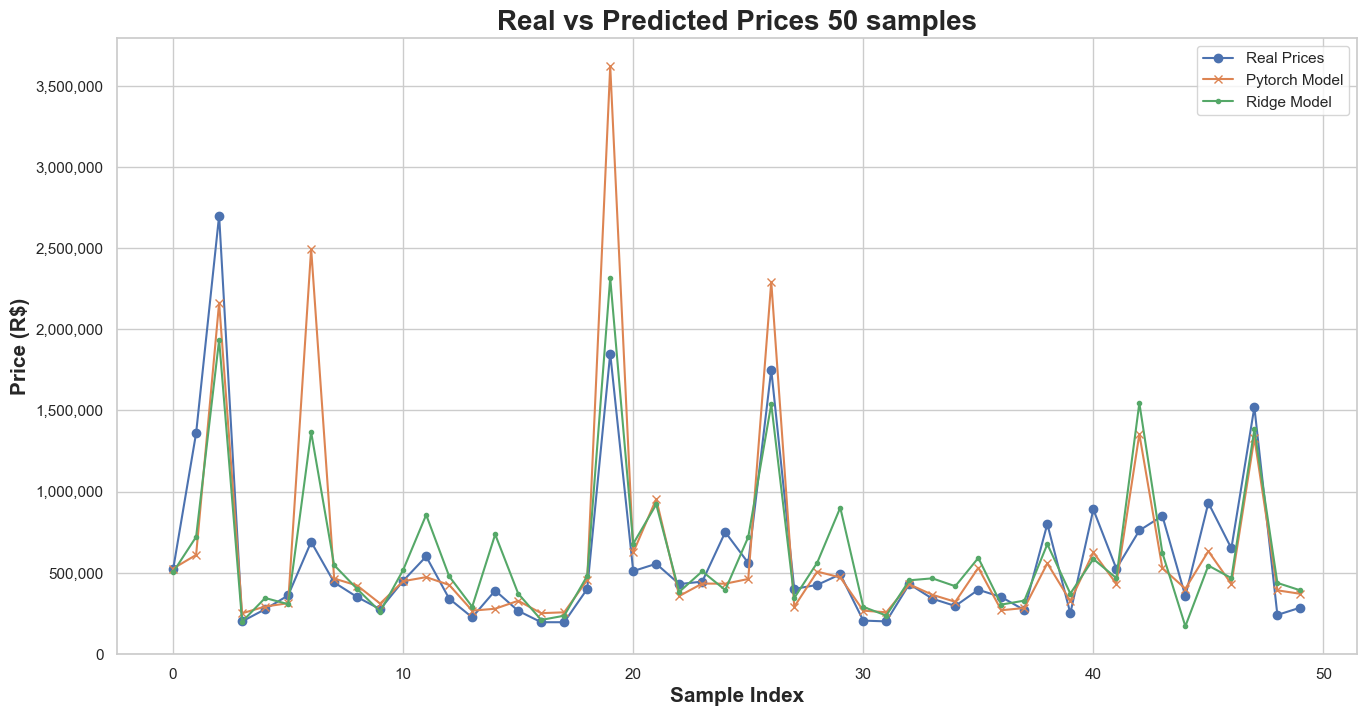

In [34]:
# Using a pre-trained model Ridge
model2 = Ridge()
model2.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
predictions_numpy2 = model2.predict(X_test)


# Plotting results
plt.figure(figsize=(16, 8))
plt.plot(y_test.values[0:50], label='Real Prices', marker='o')
plt.plot(predictions_numpy[0:50], label='Pytorch Model', marker='x')
plt.plot(predictions_numpy2[0:50], label='Ridge Model', marker='.')
plt.title('Real vs Predicted Prices 50 samples', fontsize=20, fontdict={'weight': 'bold'})
plt.xlabel('Sample Index', fontsize=15, fontdict={'weight': 'bold'})
plt.ylabel('Price (R$)', fontsize=15, fontdict={'weight': 'bold'})
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
plt.legend()
plt.show()

______
<div id="conc"></div>
<h2 align="center"> Conclusions</h2>

The results displayed in the graph above seem promising. However, it is crucial to take into consideration that the <code>data.xlsx</code> is not large and is unbalanced. This implies that these models have a significant tendency to overfit the data. If the loss on the training data is low but the loss on the test dataset is high, that is a strong indication of overfitting. I did not compare this here, as the main objective was to predict and learn PyTorch. 

______
<div id="fut"></div>
<h2 align="center"> Future Work</h2>

- Use a large and balanced dataset for predicting
- Try using a validation dataset in order to see which hyperparameters are better for this case
- Implement training functions and plotting functions

______
<div id="ref"></div>
<h2 align="center"> References</h2>

- https://www.quintoandar.com.br
- http://dados.prefeitura.sp.gov.br/dataset?res_format=SHP
- IBM Professional AI Engineering Course